In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import utils.tavr_torch as tavr_torch
from utils.tavr_torch import TAVR_3_Frame, TAVR_1_Frame, TAVR_Sequence, tavr_dataloader
from utils.visualization import display_grid, z_stretch, visualize_frame, set_figsize, get_central_slices
from utils.loss_functions import batch_mse_loss
from utils.run_model import train, test
from Models.basic_models import average_model, two_layer_basic
from Models.two_layer_concat_varsize import two_layer_concat

set_figsize(20, 15)

Training directory found, 36 series
Validation directory found, 6 series
Testing directory found, 10 series


In [2]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)


validation = TAVR_3_Frame("__valid")
val_loader = tavr_dataloader(validation, batch_size=4, shuffle=True, num_workers=2)
training = TAVR_3_Frame("__train")
train_loader = tavr_dataloader(training, batch_size=8, shuffle=True, num_workers=2)


ave_model = average_model()
model = two_layer_concat(a_layers=[16], b_layers=[16], standardize_slice=False, device=device)
loss_fn = batch_mse_loss()

using device: cuda


In [3]:
model = nn.DataParallel(model)

In [4]:
learning_rate = 3e-9
momentum = 0.90
reg = 1e-7

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg, nesterov=True)

In [5]:
train(model, optimizer, train_loader, val_loader, loss_fn, device, 
         epochs=3, print_every=30, print_level=3)


****Epoch 0 Iteration 0, loss = 398677.3750
Validation loss 124657.0469 over 81 frames
module.conv_a1.weight,   	norm: 5.1478e+00, 	update norm: 2.4348e-02 	Update/norm: 4.7298e-03
module.conv_a1.bias,   	norm: 5.2701e-01, 	update norm: 4.2862e-06 	Update/norm: 8.1330e-06
module.conv_b1.weight,   	norm: 5.1846e+00, 	update norm: 1.5451e-02 	Update/norm: 2.9801e-03
module.conv_b1.bias,   	norm: 4.0899e-01, 	update norm: 2.7271e-06 	Update/norm: 6.6678e-06
module.final.weight,   	norm: 1.3845e+00, 	update norm: 3.2198e-02 	Update/norm: 2.3256e-02
module.final.bias,   	norm: 6.1496e-02, 	update norm: 6.0461e-06 	Update/norm: 9.8318e-05

Iter 0... ... ... 
Iter 10... ... ... 
Iter 20... ... ... 
Iteration 30, loss = 14653.7012
Validation loss 16262.9502 over 81 frames
module.conv_a1.weight,   	norm: 5.1447e+00, 	update norm: 8.5401e-04 	Update/norm: 1.6600e-04
module.conv_a1.bias,   	norm: 5.2701e-01, 	update norm: 1.9475e-07 	Update/norm: 3.6954e-07
module.conv_b1.weight,   	norm: 5.1854

Validation loss 9398.0771 over 81 frames
Validation loss 1421.2905 over 81 frames


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


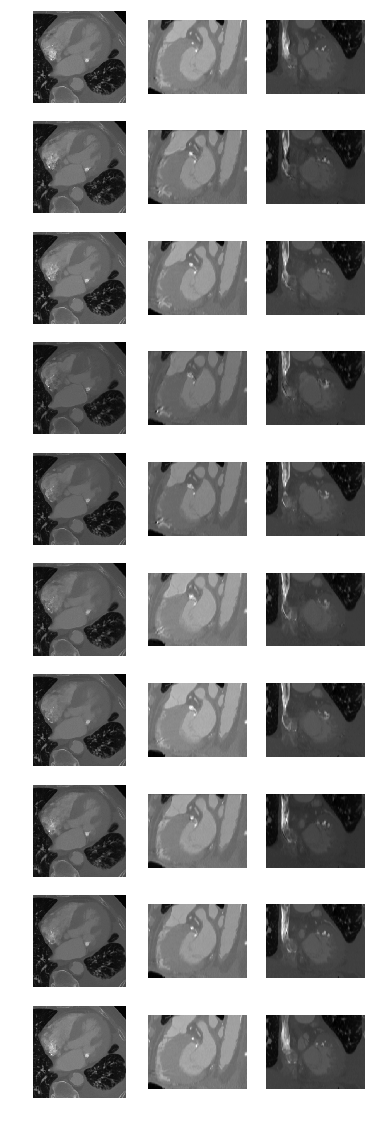

In [6]:
# One last test + visualize results on 1 validation sequence
val_seq = TAVR_Sequence("__valid")
test(model, val_loader, loss_fn, device)
test(ave_model, val_loader, loss_fn, device)

with torch.no_grad():
    model.eval()
    ave_frames = [val_seq[0][0]]
    for i in range(2,9,2):
        ave_frame = model((val_seq[0][i-2][None,:], val_seq[0][i][None,:]))
        ave_frames += [ave_frame[0][0],  val_seq[0][i]]
    ave_frames += [val_seq[0][9]]
    ave_frames_slices = []
    for f in ave_frames:
        ave_frames_slices += get_central_slices(f)
    set_figsize(6,20)
    display_grid(10, 3, ave_frames_slices)

In [8]:
# 3 more epochs
train(model, optimizer, train_loader, val_loader, loss_fn, device, 
         epochs=3, print_every=30, print_level=3)


****Epoch 0 Iteration 0, loss = 9367.1367
Validation loss 9369.4561 over 81 frames
module.conv_a1.weight,   	norm: 5.1405e+00, 	update norm: 4.0543e-04 	Update/norm: 7.8870e-05
module.conv_a1.bias,   	norm: 5.2703e-01, 	update norm: 1.4666e-07 	Update/norm: 2.7828e-07
module.conv_b1.weight,   	norm: 5.1806e+00, 	update norm: 2.7844e-04 	Update/norm: 5.3747e-05
module.conv_b1.bias,   	norm: 4.0899e-01, 	update norm: 8.7920e-08 	Update/norm: 2.1497e-07
module.final.weight,   	norm: 1.3145e+00, 	update norm: 5.3335e-04 	Update/norm: 4.0574e-04
module.final.bias,   	norm: 6.1537e-02, 	update norm: 2.0489e-07 	Update/norm: 3.3296e-06

Iter 0... ... ... 
Iter 10... ... ... 
Iter 20... ... ... 
Iteration 30, loss = 8790.0801
Validation loss 8863.1699 over 81 frames
module.conv_a1.weight,   	norm: 5.1401e+00, 	update norm: 4.0827e-04 	Update/norm: 7.9428e-05
module.conv_a1.bias,   	norm: 5.2703e-01, 	update norm: 1.3519e-07 	Update/norm: 2.5652e-07
module.conv_b1.weight,   	norm: 5.1800e+00, 

In [ ]:
train(model, optimizer, train_loader, val_loader, loss_fn, device, 
         epochs=14, print_every=30, print_level=3)


****Epoch 0 Iteration 0, loss = 5652.5103
Validation loss 6373.8164 over 81 frames
module.conv_a1.weight,   	norm: 5.1386e+00, 	update norm: 2.8972e-04 	Update/norm: 5.6382e-05
module.conv_a1.bias,   	norm: 5.2705e-01, 	update norm: 1.1001e-07 	Update/norm: 2.0872e-07
module.conv_b1.weight,   	norm: 5.1768e+00, 	update norm: 1.5350e-04 	Update/norm: 2.9652e-05
module.conv_b1.bias,   	norm: 4.0898e-01, 	update norm: 5.2815e-08 	Update/norm: 1.2914e-07
module.final.weight,   	norm: 1.2754e+00, 	update norm: 3.6409e-04 	Update/norm: 2.8546e-04
module.final.bias,   	norm: 6.1578e-02, 	update norm: 1.4156e-07 	Update/norm: 2.2989e-06

Iter 0... ... ... 
Iter 10... ... ... 
Iter 20... ... ... 
Iteration 30, loss = 5418.8008
Validation loss 6161.4565 over 81 frames
module.conv_a1.weight,   	norm: 5.1385e+00, 	update norm: 2.8214e-04 	Update/norm: 5.4907e-05
module.conv_a1.bias,   	norm: 5.2705e-01, 	update norm: 1.0899e-07 	Update/norm: 2.0680e-07
module.conv_b1.weight,   	norm: 5.1764e+00, 

Iter 60... ... ... 
Iter 70... ... ... 
Iter 80
****Epoch 4 Iteration 0, loss = 3701.9053
Validation loss 4500.0972 over 81 frames
module.conv_a1.weight,   	norm: 5.1376e+00, 	update norm: 1.9803e-04 	Update/norm: 3.8544e-05
module.conv_a1.bias,   	norm: 5.2706e-01, 	update norm: 7.5247e-08 	Update/norm: 1.4277e-07
module.conv_b1.weight,   	norm: 5.1735e+00, 	update norm: 1.0661e-04 	Update/norm: 2.0607e-05
module.conv_b1.bias,   	norm: 4.0897e-01, 	update norm: 3.1610e-08 	Update/norm: 7.7292e-08
module.final.weight,   	norm: 1.2433e+00, 	update norm: 2.5107e-04 	Update/norm: 2.0193e-04
module.final.bias,   	norm: 6.1613e-02, 	update norm: 7.8231e-08 	Update/norm: 1.2697e-06

Iter 0... ... ... 
Iter 10... ... ... 
Iter 20... ... ... 
Iteration 30, loss = 3972.5095
Validation loss 4367.9341 over 81 frames
module.conv_a1.weight,   	norm: 5.1375e+00, 	update norm: 1.9769e-04 	Update/norm: 3.8480e-05
module.conv_a1.bias,   	norm: 5.2706e-01, 	update norm: 6.0986e-08 	Update/norm: 1.1571e-

Validation loss 6400.8120 over 81 frames
Validation loss 1423.4351 over 81 frames


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


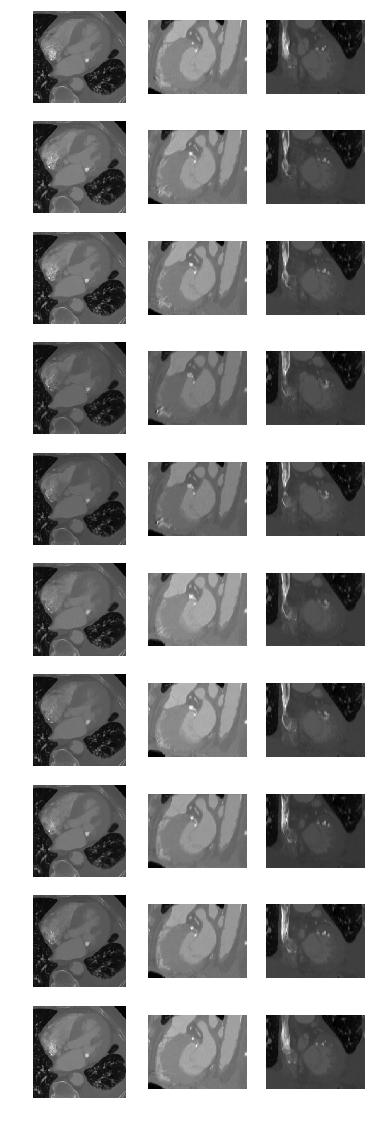

In [9]:
test(model, val_loader, loss_fn, device)
test(ave_model, val_loader, loss_fn, device)

with torch.no_grad():
    model.eval()
    ave_frames = [val_seq[0][0]]
    for i in range(2,9,2):
        ave_frame = model((val_seq[0][i-2][None,:], val_seq[0][i][None,:]))
        ave_frames += [ave_frame[0][0],  val_seq[0][i]]
    ave_frames += [val_seq[0][9]]
    ave_frames_slices = []
    for f in ave_frames:
        ave_frames_slices += get_central_slices(f)
    set_figsize(6,20)
    display_grid(10, 3, ave_frames_slices)